In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

## The Gragg-Bulirsch-Stoer Algorithm
### Modified Midpoint Method
The modified midpoint method approximates $y(x_0+h)$ by dividing the interval h into n substeps of size $\eta=h/n$, using a recursive formula. While this method maintains second-order accuracy like the original midpoint method, it has the special property that its error expansion contains only even powers of the step size ($\eta^2$, $\eta^4$, etc.).

This error structure makes the modified midpoint method particularly well-suited for Richardson extrapolation, allowing it to gain two orders of accuracy per extrapolation iteration. For example, by combining solutions computed with step sizes $\eta$ and $\eta/2$ using the formula 
$$y(x_0+h)=(4y_n-y_{n/2})/3+\mathcal{O}(\eta^4),$$ 
one can achieve fourth-order accuracy. This is the basis of the Gragg-Bulirsch-Stoer algorithm (see below).

In [2]:
def modified_midpoint_rule(f, x0, y0, h, n):
  """
  Modified mid-point rule for n sub-steps.

  Parameters:
      f:      Callable for system dynamics.
      x0:     Initial x value.
      y0:     Initial state vector.
      h:      Step size.
      n:      Number of sub-steps.

  Returns:
      x, y : Time points and state estimates at each sub-step.
  """
  nx = n + 1
  eta = h / n
  x = np.linspace(x0, x0+h, nx)
  y = np.zeros((len(y0), nx))

  y[:, 0] = y0
  y[:, 1] = y0 + eta * f(x0, y0)
  for i in range(2, nx):
      y[:, i] = y[:, i - 2] + 2 * eta * f(x[i - 1], y[:, i - 1])
  y[:, -1] = 0.5 * (y[:, -1] + y[:, -2] + eta * f(x[-1], y[:, -1]))
  return x, y

### The Gragg-Bulirsch-Stoer Method
The Gragg-Bulirsch-Stoer (GBS) method combines the modified midpoint method with Richardson extrapolation to achieve a highly accurate ODE solution. It begins by computing the solution with the modified midpoint method for a sequence of substeps $n_j = 2(j+1)$ with step sizes $\eta_j = \frac{h}{n_j}$ for $j = 0,1,2,\ldots$. Then, Neville's algorithm is used to extrapolate these solutions to the limit $\eta \to 0$. The extrapolated values are organized in a lower triangular matrix $\mathbf{T}$ where 
$$
\begin{align}
T_{j,0} &= y_j\quad\text{(the solution computed with step size $h_j$) and}\\
T_{j,k+1} &= T_{jk} + \frac{T_{jk} - T_{j-1,k}}{(n_j/n_{j-k-1})^2 - 1}\quad \text{for $k=0,1,\ldots,j-1$.}
\end{align}
$$
The most accurate approximation is given by the diagonal element $T_{k,k}$.

A key advantage of the GBS method is its built-in error estimation capability. The error can be approximated as $\epsilon_j = |T_{j,j} - T_{j,j-1}|$, which allows for adaptive step size control. Since $T_{kk}$ has order $2(k+1)$ and $T_{k,k-1}$ has order $2k$, the relation between error and step size is $\epsilon_j \propto h^{2j+1}$. This combination of high-order accuracy and adaptive step size control makes the GBS method particularly efficient for solving ODEs that require high precision.

In [3]:
def gragg_bulirsch_stoer_step(f, x0, y0, h, tol, n_refine_max = 8):
  """
  Single step of the Bulirsch-Stoer method with extrapolation.

  Parameters:
      f:            RHS of ODE y' = f(x, y).
      x0:           Initial x value.
      y0:           Initial y value.
      h:            Step size.
      tol:          Error tolerance.
      n_refine_max: Maximum number of sub_steps.

  Returns:
      yF:           Final state.
      converged:    True if converged to tolerance.
      error:        Error estimate.
      n_refine:     Number of sub-steps needed to reach tolerance.
  """
  n = 2 * np.arange(1, n_refine_max + 1)
  ny = len(y0)
  tol = np.full(ny, tol) if np.isscalar(tol) else tol

  T = np.zeros((ny, n_refine_max, n_refine_max))
  E = np.zeros((ny, n_refine_max))

  for j in range(n_refine_max):
      _, y = modified_midpoint_rule(f, x0, y0, h, n[j])
      T[:, j, 0] = y[:, -1]

      if j > 0:
          for k in range(0, j):
              num = T[:, j, k] - T[:, j - 1, k]
              den = (n[j] / n[j - k - 1])**2 - 1
              T[:, j, k+1] = T[:, j, k] + num / den

          E[:, j] = np.abs(T[:, j, j]-T[:, j, j - 1])

          if np.all(E[:, j] < tol):
              return T[:, j, j], True, E[:, j], j+1

  return T[:, -1, -1], False, E[:, -1], n_refine_max


def gragg_bulirsch_stoer( f, x0, y0, x_end, h_first = 0.1, tol = 1e-6, 
                            n_refine_max = 8, max_steps = 10000):
    """
    Solves an IVP using the Bulirsch-Stoer method for high-accuracy solutions.

    Parameters:
        f:            Callable for system dynamics, dy/dx = f(x, y).
        x0:           Initial x value.
        y0:           Initial y value.
        x_end:        Final x value.
        h_first:      Initial step size.
        tol: Error    tolerance.
        n_refine_max: Maximum number of refinements.
        max_steps:    Maximum number of steps.

    Returns:
        x_vals:       Array of x values.
        y_vals:       Array of y values.
        err_vals:     Array of error estimates.
    """
    x_vals, y_vals, err_vals = np.array(x0), np.array([y0]), 0.*np.array([y0])
    x, h, num_steps = x0, h_first, 0

    while x < x_end:
        h = min(h, (x_end - x)+np.finfo(float).eps )
        num_steps += 1
        yF, converged, error, nrefine = gragg_bulirsch_stoer_step(f, x, y_vals[-1], h, tol, n_refine_max)

        if converged:
          x        = x + h
          x_vals   = np.append( x_vals, x )
          y_vals   = np.vstack( (y_vals, yF) )
          err_vals = np.vstack( (err_vals, error) )
          # Increase step size
          h *= min(2, np.max(0.9 * (tol / error)**(1. / (2 * nrefine))))
        else:
          # Reduce step size
          h *= max(0.1, np.min(0.9 * (tol / error)**(1. / (2 * nrefine))))

        if num_steps > max_steps:
          raise RuntimeError("Maximum number of steps exceeded.")
            
    return x_vals, y_vals, err_vals

### Compute van der Pol Oscillator with GBS Method

The Van der Pol oscillator (after Dutch physicist Balthasar van der Pol) is a non-linear dynamical system that exhibits self-sustained oscillations. Mathematically, it is described by the second-order differential equation 
$$y'' - \mu(1-y^2)y' + y = 0,$$ 
where $\mu > 0$ is a scalar parameter controlling the strength of the nonlinearity. This system can be rewritten as a first-order system: 
$$
\begin{align*}
y_0' &= y_1 \\
y_1' &= \mu(1-y_0^2)y_1 - y_0.
\end{align*}
$$
In the limit $\mu \to 0$, the Van der Pol oscillator reduces to a simple harmonic oscillator. We assume initial data $y_0(0) = 2$ and $y_1(0) = 0$, as well as $\mu = 10$.

In [4]:
# Example: van der pol oscillator
mu = 10
def f_vanderpol(t, y):
    return np.array([y[1], mu*(1-y[0]**2)*y[1]-y[0]])

t0, t_end = 0, 30
y0 = [2.0,0.0]

# Solve using GBS
tol = 1e-6
t_vals_bs, y_vals_bs, err_vals_bs = gragg_bulirsch_stoer(f_vanderpol, t0, y0, t_end, tol=tol,n_refine_max=5, max_steps=20000)
print(f"GBS: Number of steps = {len(t_vals_bs)} to achieve tolerance = {tol}")

GBS: Number of steps = 133 to achieve tolerance = 1e-06


### Plot results and error estimate

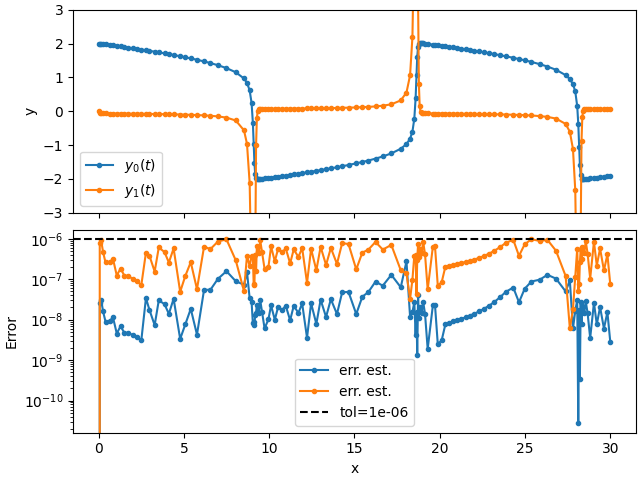

In [5]:
fig, ax = plt.subplots(2, 1,sharex=True, layout='constrained')
ax[0].plot(t_vals_bs, y_vals_bs[:, 0], '.-', label='$y_0(t)$')
ax[0].plot(t_vals_bs, y_vals_bs[:, 1], '.-', label='$y_1(t)$')
ax[0].set_ylim(-3,3)
ax[0].set_ylabel('y')
ax[0].legend()

ax[1].plot(t_vals_bs, err_vals_bs, '.-', label='err. est.')
ax[1].axhline(tol, color='k', linestyle='--', label='tol={}'.format(tol))
ax[1].set_yscale('log')
ax[1].set_xlabel('x')
ax[1].set_ylabel('Error')
ax[1].legend()
